In [1]:
import petsc4py

petsc4py.init(["-saws_port_auto_select"])
from petsc4py import PETSc

import os

os.environ["PLOT_LIB_PATH"] = "/cluster/home/mpundir/dev"

In [6]:
import jax

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_platforms", "cpu")
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
import jax.numpy as jnp

from functools import partial

import cmcrameri.cm as cmc
import numpy as np

import matplotlib.pyplot as plt

from functools import partial
from spectralsolver.operators import spatial, tensor, fourier_galerkin
from spectralsolver import FFT, IFFT
from spectralsolver.solvers.linear import conjugate_gradient_while
from spectralsolver.solvers.nonlinear import newton_krylov_solver
from skimage.morphology import disk, rectangle, ellipse

In [ ]:
import sys


sys.path.append(os.environ["PLOT_LIB_PATH"])
from plottwist.decorators import plot, subplots, imshow, imshow_grid

In [7]:
N = 299
shape = (N, N)
length = 1.0


# @imshow(cmap=cmc.managua, enable=True)
def create_structure(N):
    Hmid = int(N / 2)
    Lmid = int(N / 2)
    r = int(N / 4)

    structure = np.ones((N, N))
    structure[Hmid - r : Hmid + r + 1, Lmid - r : Lmid + r + 1] -= disk(r)

    return structure


structure = create_structure(N)

In [8]:
fft = FFT(N=N, ndim=2)
ifft = IFFT(N=N, ndim=2)

## material parameters

In [9]:
# material parameters + function to convert to grid of scalars
@partial(jax.jit, static_argnames=["inclusion", "solid"])
def param(X, inclusion, solid):
    props = inclusion * jnp.ones_like(X) * (1 - X) + solid * jnp.ones_like(X) * (X)
    return props

In [10]:
# material parameters
phase_contrast = 1 / 1e3

# lames constant
lambda_modulus = {"solid": 1.0, "inclusion": phase_contrast}
shear_modulus = {"solid": 1.0, "inclusion": phase_contrast}

bulk_modulus = {}
bulk_modulus["solid"] = lambda_modulus["solid"] + 2 * shear_modulus["solid"] / 3
bulk_modulus["inclusion"] = (
    lambda_modulus["inclusion"] + 2 * shear_modulus["inclusion"] / 3
)

In [11]:
λ0 = param(
    structure, inclusion=lambda_modulus["inclusion"], solid=lambda_modulus["solid"]
)  # lame parameter
μ0 = param(
    structure, inclusion=shear_modulus["inclusion"], solid=shear_modulus["solid"]
)  # lame parameter
K0 = param(structure, inclusion=bulk_modulus["inclusion"], solid=bulk_modulus["solid"])

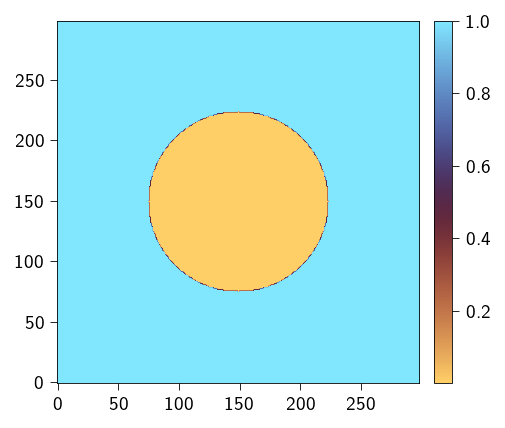

Array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float64)

In [8]:
imshow(cmap=cmc.managua, enable=True)(lambda x: x)(λ0)

## linear elastic constitutive relation

Now, we define the stress-strain relationship, for this we directly derive the `stress` function by autodifferentiating the `strain energy` expression.

$$\psi = \dfrac{1}{2}(\text{tr}(\varepsilon_{ii})^2 + \mu \text{tr}(\varepsilon_{ij}\varepsilon_{jk} )$$
$$\sigma_{ij} = \dfrac{\partial \psi}{\partial \varepsilon_{ij}}$$

For FFT scheme, we define the above strain expression for each grid point ($x,y$)

$$\psi_{xy} = \dfrac{1}{2}(\text{tr}(\varepsilon_{iixy})^2 + \mu \text{tr}(\varepsilon_{ijxy}\varepsilon_{jkxy} ) $$
$$\sigma_{ijxy} = \dfrac{\partial \psi_{xy}}{\partial \varepsilon_{ijxy}}$$


In [12]:
H, L = structure.shape
dx = length / H
dy = length / L

ndim = len(structure.shape)
shape = [
    N,
] * ndim

In [13]:
@jax.jit
def strain_energy(eps):
    eps_sym = 0.5 * (eps + tensor.trans2(eps))
    energy = 0.5 * jnp.multiply(λ0, tensor.trace2(eps_sym) ** 2) + jnp.multiply(
        μ0, tensor.trace2(tensor.dot22(eps_sym, eps_sym))
    )
    return energy.sum()


sigma = jax.jit(jax.jacrev(strain_energy))

## fft helpers and operators

Projection tensor

In [14]:
Ghat = fourier_galerkin.compute_projection_operator(
    grid_size=(N,) * ndim, operator=spatial.Operator.rotated_difference, length=length
)

In [15]:
# functions for the projection 'G', and the product 'G : K : eps'
@jax.jit
def G(A2):
    return jnp.real(ifft(tensor.ddot42(Ghat, fft(A2)))).reshape(-1)


@jax.jit
def G_K_deps(depsm, additionals=None):
    depsm = depsm.reshape(ndim, ndim, N, N)
    return G(sigma(depsm))

## newton-raphson method

In [16]:
@jax.jit
def newton_raphson(state, n):
    dF, b, F, Fn = state

    error = jnp.linalg.norm(dF) / Fn
    jax.debug.print("residual={}", error)

    def true_fun(state):
        dF, b, F, Fn = state

        dF, iiter = conjugate_gradient_while(
            atol=1e-8, A=G_K_deps, b=b
        )  # solve linear system using CG

        dF = dF.reshape(ndim, ndim, N, N)
        F = jax.lax.add(F, dF)  # update DOFs (array -> tensor.grid)
        b = -G_K_deps(F)  # compute residual

        return (dF, b, F, Fn)

    def false_fun(state):
        return state

    return jax.lax.cond(error > 1e-8, true_fun, false_fun, state), n

## testing elastic subproblem for a loaded state

In [17]:
eps = jnp.zeros([ndim, ndim, N, N])

deps = jnp.zeros([ndim, ndim, N, N])
deps = deps.at[0, 0].set(1e-1)
deps = deps.at[1, 1].set(1e-1)

# initial residual: distribute "DE" over grid using "K4"
b = -G_K_deps(deps)
eps = jax.lax.add(eps, deps)
En = jnp.linalg.norm(eps)

In [18]:
state = (deps, b, eps)
final_state = newton_krylov_solver(
    state,
    tol=1e-8,
    A=G_K_deps,
    max_iter=10,
    additionals=None,
    krylov_solver=conjugate_gradient_while,
    krylov_tol=1e-8,
    krylov_max_iter=40,
)

AttributeError: 'jaxlib._jax.PjitFunction' object has no attribute 'residual'

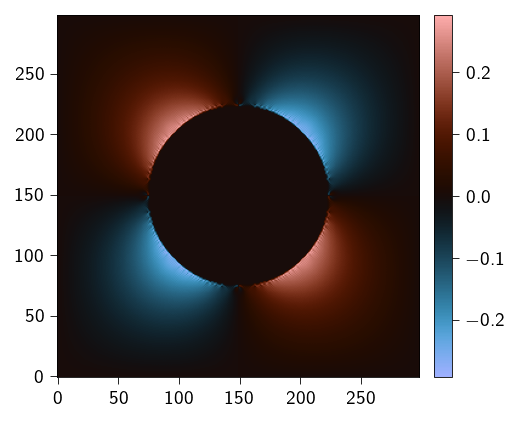

Array([[ 1.51344175e-04, -1.71326970e-04,  1.31133529e-04, ...,
        -1.31133529e-04,  1.71326970e-04, -1.51344175e-04],
       [-1.71326970e-04,  1.11151154e-04, -2.31273668e-04, ...,
         2.31273668e-04, -1.11151154e-04,  1.71326970e-04],
       [ 1.31133529e-04, -2.31273668e-04,  3.07701675e-05, ...,
        -3.07701675e-05,  2.31273668e-04, -1.31133529e-04],
       ...,
       [-1.31133529e-04,  2.31273668e-04, -3.07701674e-05, ...,
         3.07701675e-05, -2.31273668e-04,  1.31133529e-04],
       [ 1.71326970e-04, -1.11151154e-04,  2.31273668e-04, ...,
        -2.31273668e-04,  1.11151154e-04, -1.71326970e-04],
       [-1.51344175e-04,  1.71326970e-04, -1.31133529e-04, ...,
         1.31133529e-04, -1.71326970e-04,  1.51344175e-04]],      dtype=float64)

In [16]:
sig = sigma(final_state[2])
imshow(cmap=cmc.berlin, enable=True)(lambda x: x)(sig.at[0, 1].get() * (structure))

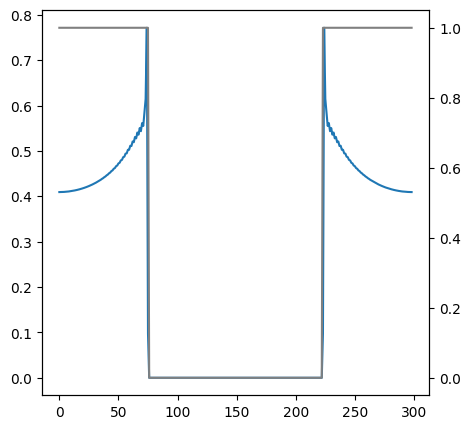

In [17]:
plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.plot(sig.at[0, 0].get()[150, :] * structure[150, :])
# ax.set_ylim(top=1e-4, bottom=1e-12)


ax2 = ax.twinx()
ax2.plot(structure[150, :], color="gray")
plt.show()

## Testing PETSc Newton-Krylov solver

In [41]:
class ElasticProblem:
    def __init__(self, b, ndim, N):
        self.ndim = ndim
        self.N = N
        self.b = b
        self.compute = G_K_deps
        # self.jac = jax.jacfwd(G_K_deps)

    def function(self, snes, X, F):
        x = jnp.array(X.array())
        f = self.compute(x)  # + self.b
        F[:] = f

    # for the case when we need to pass jacobian as well to petsc solver
    """def jacobian(self, snes, X, J, P):
        x = X.getArray()
        J.zeroEntries()
        J[:, :] = self.jac(x)
        J.assemble()"""

In [42]:
deps = jnp.zeros([ndim, ndim, N, N])
deps = deps.at[0, 0].set(1e-1)
deps = deps.at[1, 1].set(1e-1)

# initial residual: distribute "DE" over grid using "K4"
b0 = -G_K_deps(deps)
b0 = b0.reshape(-1)

elastic_problem = ElasticProblem(b0, ndim, N)

In [43]:
# register the function in charge of
# computing the nonlinear residual

snes = PETSc.SNES().create(comm=PETSc.COMM_SELF)
f = PETSc.Vec().createSeq(ndim * ndim * N * N)
snes.setFunction(elastic_problem.function, f)

# J = PETSc.Mat().createDense(size=[ndim * ndim * N * N, ndim * ndim * N * N], comm=PETSc.COMM_SELF)
# J.setUp()
# snes.setJacobian(elastic_problem.jacobian, J, J)

# snes.getKSP().setType("cg")
# snes.getKSP().getPC().setType("jacobi")


snes.setUseMF(True)
snes.getKSP().setType("gmres")


snes.setType("newtonls")
snes.setTolerances(atol=1e-8, rtol=1e-8)
snes.setConvergenceHistory()
snes.setConvergedReason(reason=PETSc.SNES.ConvergedReason.CONVERGED_FNORM_ABS)
snes.getKSP().setConvergedReason(reason=PETSc.KSP.ConvergedReason.CONVERGED_RTOL)
snes.setMonitor(lambda _, it, residual: print(it, residual))


b, sol = f.duplicate(), f.duplicate()
sol.set(0.0)  # zero inital guess
b.setArray(b0.at[:].get())

snes.solve(b, sol)
print(snes.is_converged)
print(PETSc.SNES.ConvergedReason.CONVERGED_FNORM_ABS == snes.getConvergedReason())
print(snes.getKSP().getConvergedReason())


snes.view()
_ = snes.destroy()

Error: error code 101
[0] SNESSolve() at /tmp/pip-install-o1uwkkfz/petsc_14823b45a6064788ba6b7c9dd1fcc018/src/snes/interface/snes.c:4846
[0] SNESSolve_NEWTONLS() at /tmp/pip-install-o1uwkkfz/petsc_14823b45a6064788ba6b7c9dd1fcc018/src/snes/impls/ls/ls.c:169
[0] SNESComputeFunction() at /tmp/pip-install-o1uwkkfz/petsc_14823b45a6064788ba6b7c9dd1fcc018/src/snes/interface/snes.c:2476

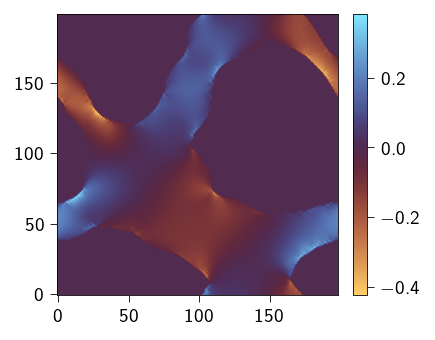

In [53]:
sig_petsc = sigma(sol.getArray().reshape(ndim, ndim, N, N))
imshow(cmc.managua, return_val=False)(lambda x: x)(sig_petsc.at[0, 1].get() * structure)